##  Warm-up: Basic deterministic under-sampling
In this first notebook, we start with simple deterministic under-sampling
using low-freq and high-freq only masks. Hence we want to generate a sampling mask $\Omega$ such that $y = F_{\Omega} x$ where $x$ is the original image. The data $y$ is then corrupted by additive noise $b$. 
We consider: 
* a low-frequency mask, i.e. where $\Omega$ is defined as a square around the center of k-space. 
* a high-frequency mask,  i.e. where $\Omega$ is defined as a inner square sticked to the max frequency $K_{max}$.

* Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
* Date: 04/01/2019
* Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**

<IPython.core.display.Javascript object>


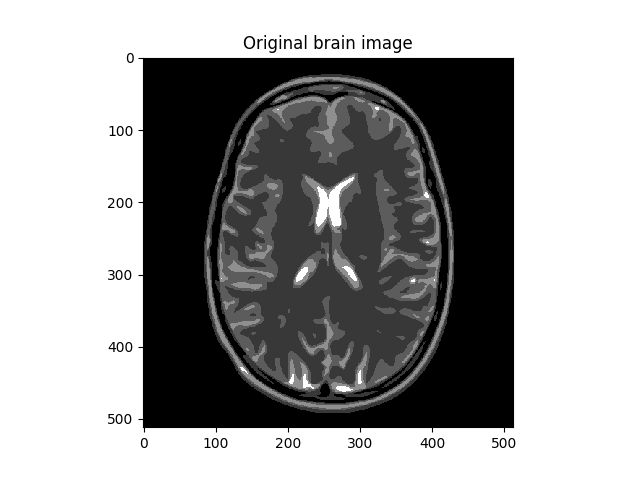

In [4]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg
import sys

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt

from skimage import data, io
#get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd,"../data")
img_size = 512   #256
FOV = 0.2 #field of view in m
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename)
#mri_img = io.imread(mri_filename, as_gray=True)
#print(mri_img.dtype)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.title("Original brain image")
plt.show()
#plt.close()

<IPython.core.display.Javascript object>


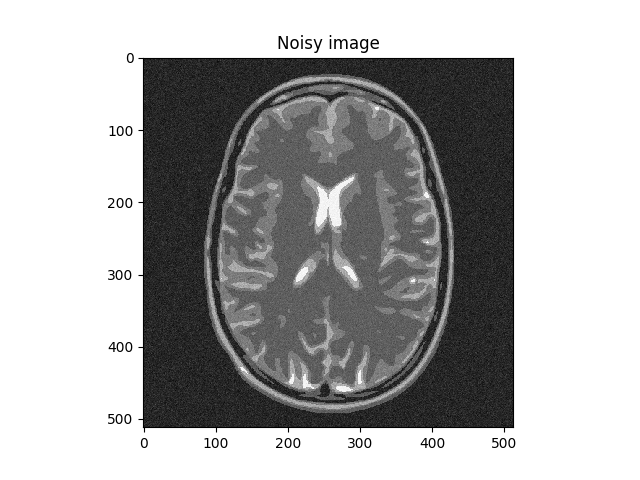

In [5]:
# Plot Noisy image
new_img = np.copy(mri_img.astype('float64'))
new_img += np.random.randn(*mri_img.shape) * 10.
#print(mri_img.shape)

if 1:
    plt.figure()
    plt.imshow(new_img, cmap='Greys_r')
    plt.title("Noisy image")
    plt.show()


<IPython.core.display.Javascript object>


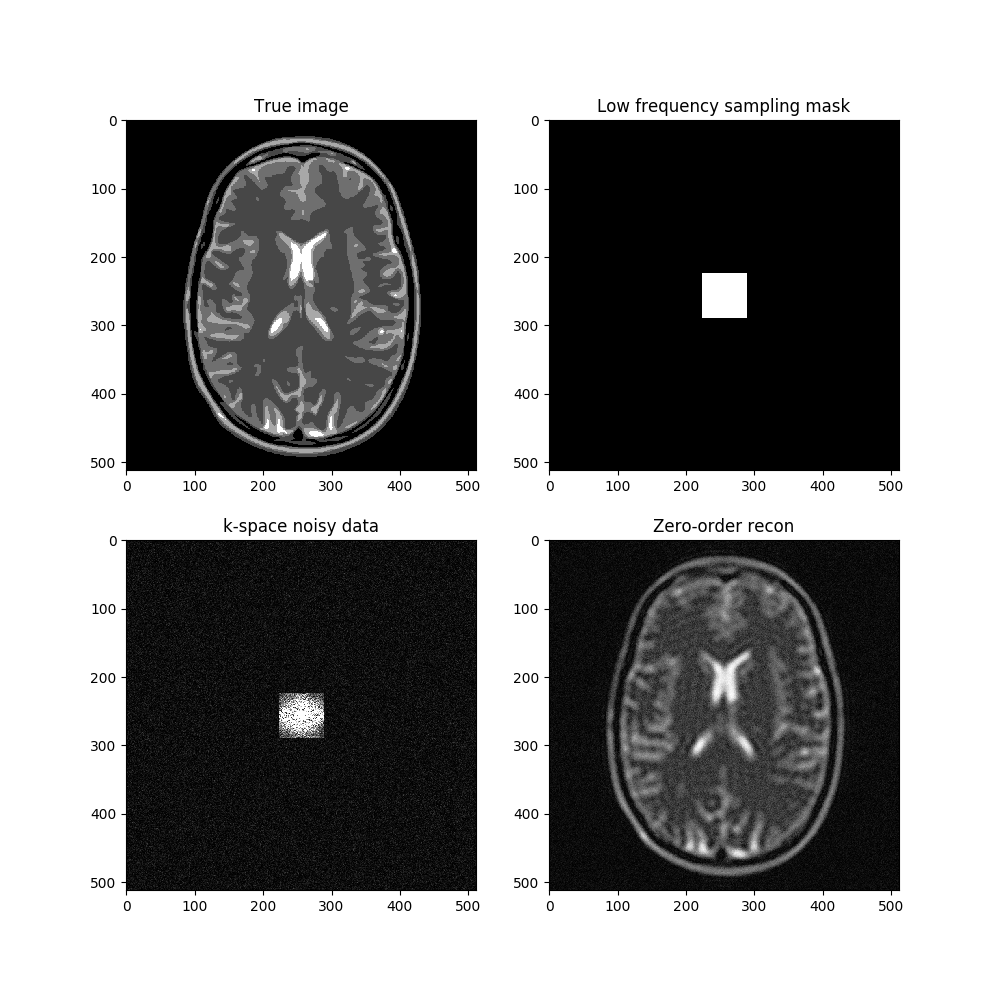

In [30]:
#import numpy.fft as fft
# Generate trivial Cartesian sampling masks
import numpy as np
import matplotlib.pyplot as plt
img_size = 512

mask="low_res"
factor_ctr = 8
#mask="high_res"

#low freq/k-space center mask
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
#idx_vec= np.linspace( img_size/2-np.floor(low_res_size/2),img_size/2+np.floor(low_res_size/2),low_res_size)
#low_res_size = (int)(img_size/factor_ctr +1)
low_res_size = (int)(img_size/factor_ctr+1)
idx_vec= np.linspace(img_size/2 - np.floor(low_res_size/2),img_size/2 + np.floor(low_res_size/2),low_res_size)
idx_vec_ =  idx_vec.astype("int")

for i in idx_vec_:
    for j in idx_vec_:
        kspace_mask[i,j]=1.

if 0: # to debug
    vec =  np.array([idx_vec.astype("int")])
    zero_vfill = np.zeros( (1, (int)((img_size-low_res_size)/2)), dtype="int")
    line_vec = np.concatenate((zero_vfill, vec, zero_vfill), axis=1)
    center_lines = np.tile(line_vec, (low_res_size,1))
    kspace_mask[center_lines] =1.

if 0:
    plt.figure()
    plt.imshow(kspace_mask, cmap='Greys_r')
    plt.title("Sampling mask")
    plt.show()

norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the subsampled kspace
kspace_data = np.fft.fftshift(fft(mri_img)) * kspace_mask   # put the 0-freq in the middle of axes as
                                                            # mask is defined wrt center of k-space in the middle

    #noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))            # get back to the convention


fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='Greys_r')
axs[0,1].set_title("Low frequency sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data")
axs[1,1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()


/volatile/ciuciu/work/2019/COSMIC/19.04_ISBI_Tutorial/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


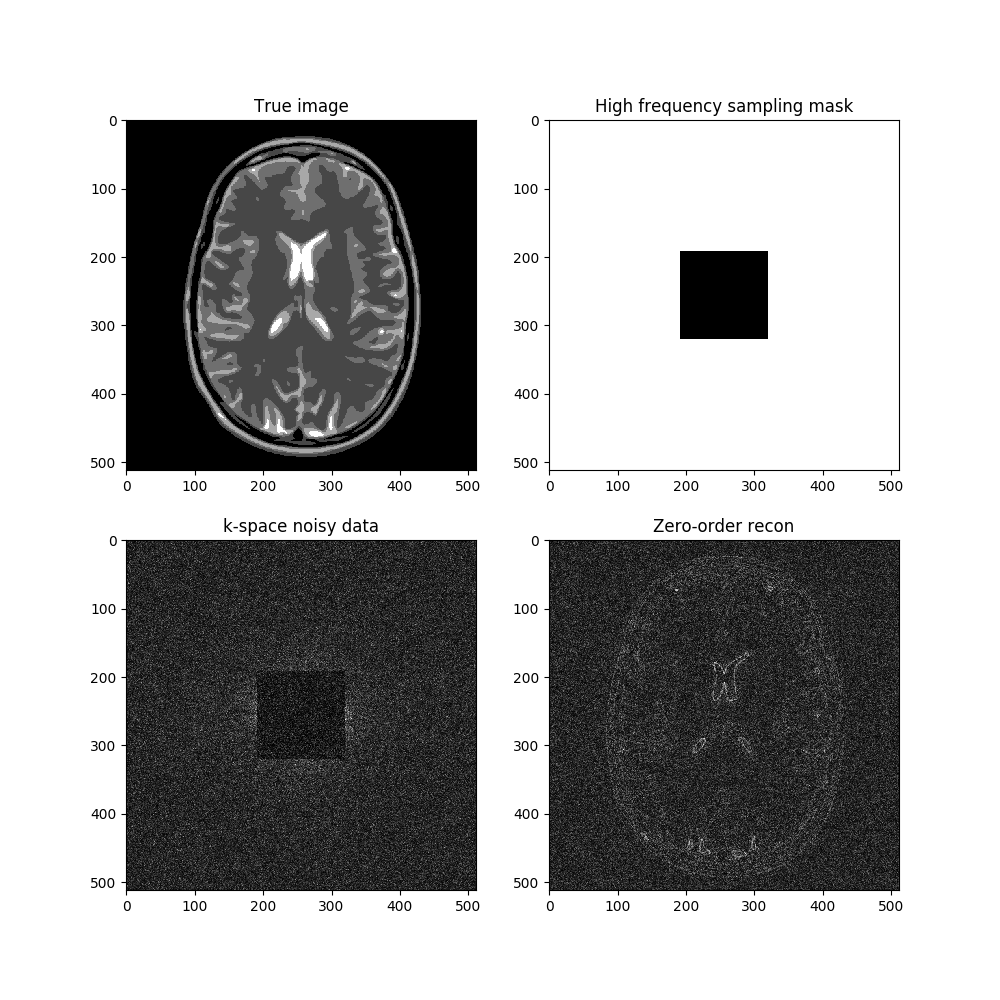

In [18]:
#high freq only
kspace_mask = np.ones((img_size,img_size), dtype="float64")
low_res_size = img_size/(factor_ctr/2) +1 
idx_vec= np.linspace( img_size/2-np.floor(low_res_size/2),img_size/2+np.floor(low_res_size/2),low_res_size)
idx_vec_ =  idx_vec.astype("int")
for i in idx_vec_:
    for j in idx_vec_:
        kspace_mask[i,j]=0.


# Generate the subsampled kspace
kspace_data = np.fft.fftshift(fft(new_img)) * kspace_mask   # put the 0-freq in the middle of axes as
                                                            # mask is defined wrt center of k-space in the middle

#noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))            # get back to the convention


fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='Greys_r')
axs[0,1].set_title("High frequency sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=1*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data")
axs[1,1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()
